In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os, re, datetime

In [3]:
# Based on a special log file produced by this branch in real-time into `~/.rusty-kaspa/kaspa-mainnet/logs/mempool-stats.log`
path = 'mempool-stats.log'
names = ['prio_feerate', 'prio_secs', 'norm_feerate', 'norm_secs', 'mid_feerate', 'mid_secs', 'low_feerate', 'low_secs', 
         'mempool_count', 'mempool_mass', 'bbt_min_feerate', 'bbt_median_feerate', 'bbt_max_feerate']
df = pd.read_csv(path, names=names)

In [4]:
len(df)

92709

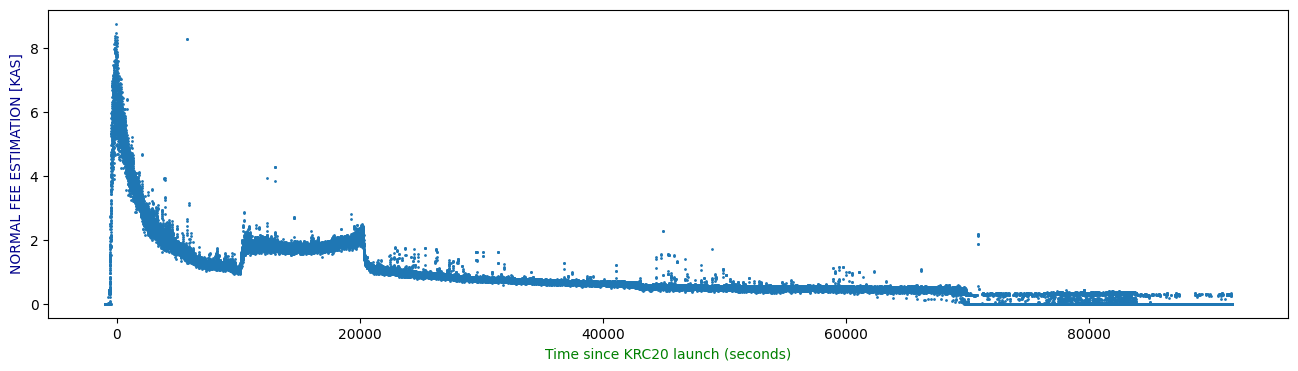

In [56]:
x = np.arange(len(df))
y = df['norm_feerate']

plt.figure(figsize=(16, 4))
plt.scatter(x - 1000, y * 2000 / 100_000_000, s=1)
plt.ylabel('NORMAL FEE ESTIMATION [KAS]', color='darkblue')
plt.xlabel('Time since KRC20 launch (seconds)', color='green')
plt.show()

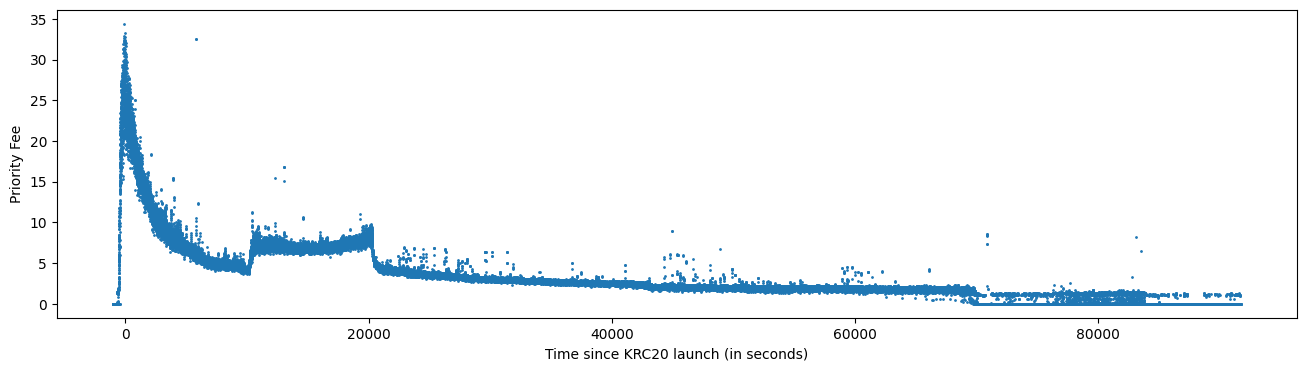

In [6]:
x = np.arange(len(df))
y = df['prio_feerate']

plt.figure(figsize=(16, 4))
plt.scatter(x - 1000, y * 2000 / 100_000_000, s=1)
plt.ylabel('Priority Fee')
plt.xlabel('Time since KRC20 launch (in seconds)')
plt.show()

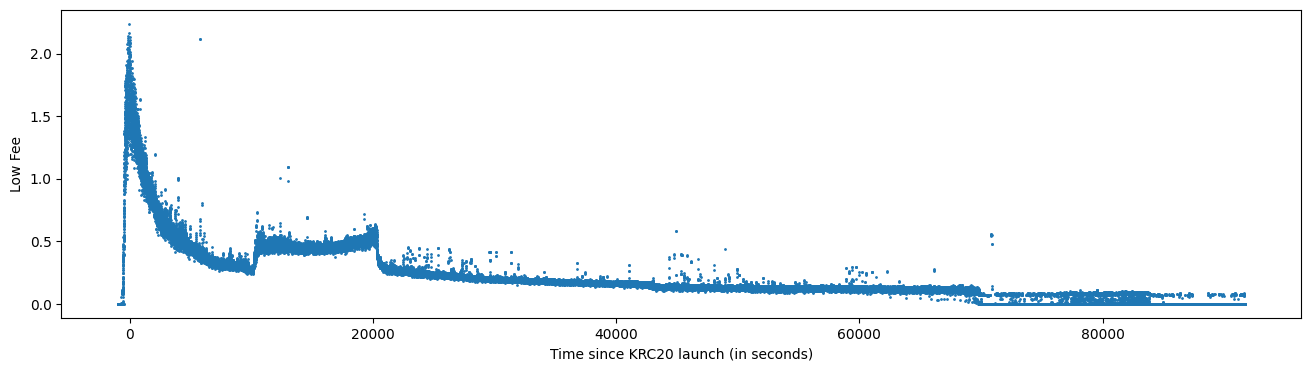

In [7]:
x = np.arange(len(df))
y = df['low_feerate']

plt.figure(figsize=(16, 4))
plt.scatter(x - 1000, y * 2000 / 100_000_000, s=1)
plt.ylabel('Low Fee')
plt.xlabel('Time since KRC20 launch (in seconds)')
plt.show()

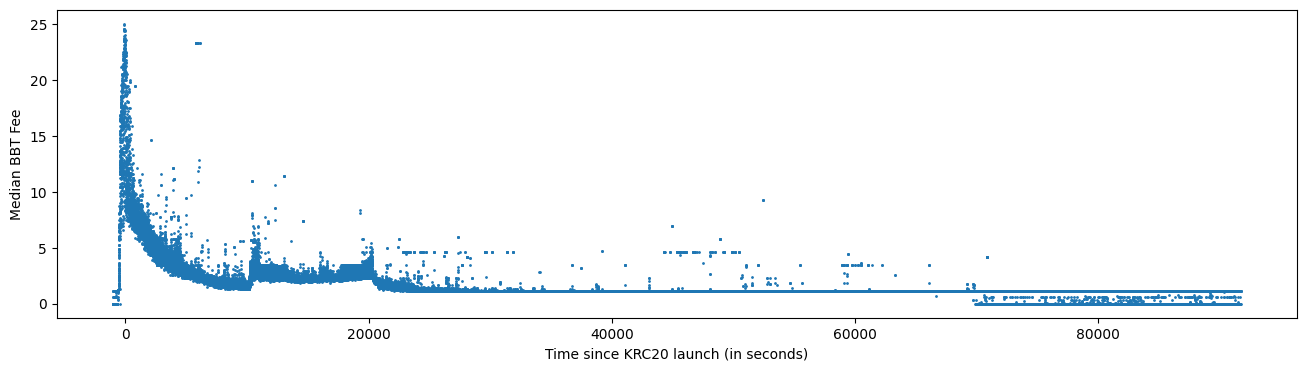

In [8]:
x = np.arange(len(df))
y = df['bbt_median_feerate']

plt.figure(figsize=(16, 4))
plt.scatter(x - 1000, y * 2000 / 100_000_000, s=1)
plt.ylabel('Median BBT Fee')
plt.xlabel('Time since KRC20 launch (in seconds)')
plt.show()

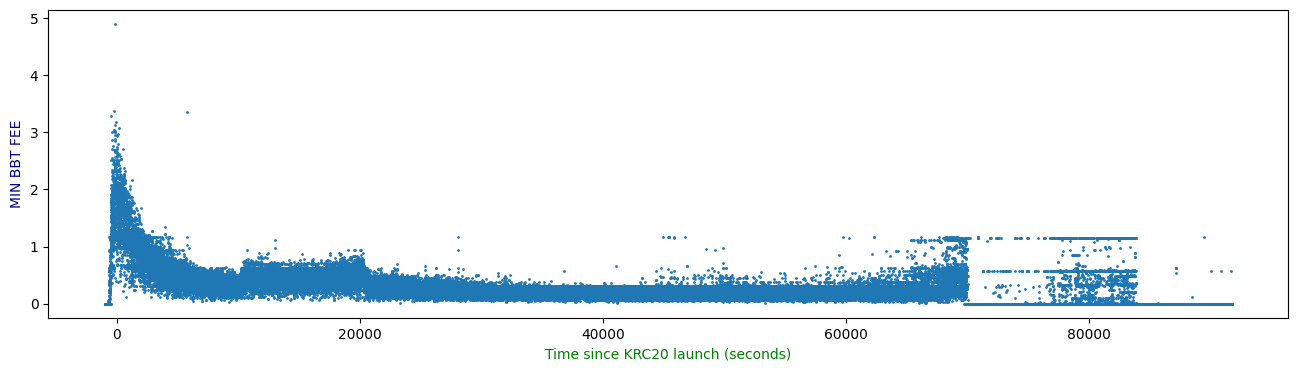

In [55]:
x = np.arange(len(df))
y = df['bbt_min_feerate']

plt.figure(figsize=(16, 4))
plt.scatter(x - 1000, y * 2000 / 100_000_000, s=1)
plt.ylabel('MIN BBT FEE', color='darkblue')
plt.xlabel('Time since KRC20 launch (seconds)', color='green')
plt.show()

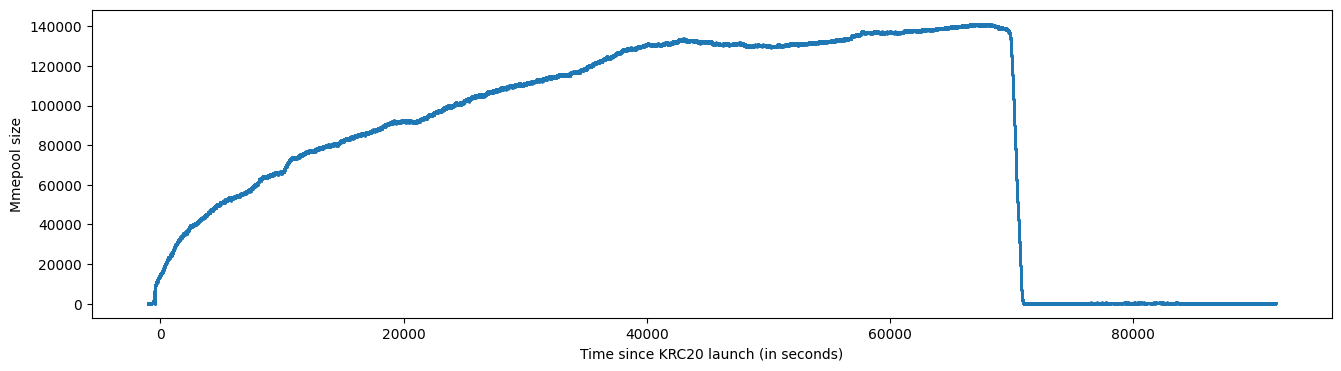

In [10]:
x = np.arange(len(df))
y = df['mempool_count']

plt.figure(figsize=(16, 4))
plt.scatter(x - 1000, y, s=1)
plt.ylabel('Mmepool size')
plt.xlabel('Time since KRC20 launch (in seconds)')
plt.show()

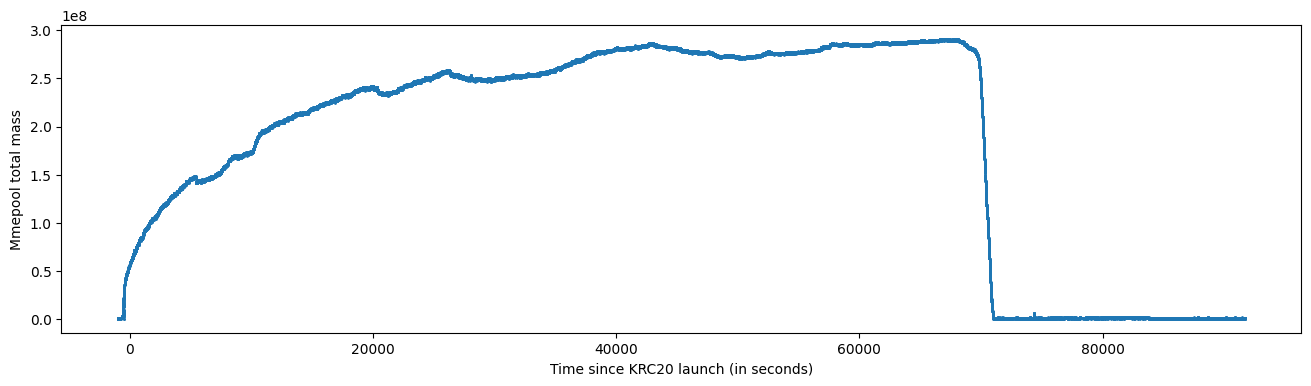

In [11]:
x = np.arange(len(df))
y = df['mempool_mass']

plt.figure(figsize=(16, 4))
plt.scatter(x - 1000, y, s=1)
plt.ylabel('Mmepool total mass')
plt.xlabel('Time since KRC20 launch (in seconds)')
plt.show()

In [30]:
z = df['norm_feerate'] > 2
u = df['mempool_mass'] < 400_000
sum(z & u)
# df.index[z & u].tolist()

30

In [13]:
len(z), sum(z), len(u), sum(u)

(92709, 74666, 92709, 5584)

In [14]:
# Extracted from node logs by `cat rusty-kaspa.log.1 rusty-kaspa.log | grep -e e-tps -e "Mempool sample" > etps.log`
etps_file = 'etps.log'
etps = []
utps = []
counts = []
tps_timestamp = []
count_timestamp = []
thresh = datetime.datetime.fromisoformat('2024-09-15 12:00:00.000+00:00').timestamp()
with open(etps_file) as file:
    for line in file:
        # print(line)
        # break
        t = datetime.datetime.fromisoformat(line[:line.find(' [')]).timestamp()
        if t < thresh:
            continue
        s = re.search('u-tps, (.+?)% e-tps', line)
        if s:
            etps_val = float(s.group(1))
            utps_val = float(re.search('stats: (.+?) u-tps', line).group(1))
            etps.append(etps_val)
            utps.append(utps_val)
            tps_timestamp.append(t)
            # print(etps_val, utps_val)
            # break
        else:
            # print(line)
            # break
            mempool_count = float(re.search('Mempool sample: (.+?) ready out', line).group(1))
            counts.append(mempool_count)
            count_timestamp.append(t)

In [15]:
len(etps), len(utps), len(tps_timestamp), len(counts), len(count_timestamp)

(17617, 17617, 17617, 17617, 17617)

In [16]:
i, j = 0, 0
orig_data = []
while i < len(tps_timestamp) and j < len(count_timestamp):
    t_i = tps_timestamp[i]
    t_j = count_timestamp[j]
    if t_i + 1 < t_j:
        i += 1
        continue
    if t_j + 1 < t_i:
        j += 1
        continue
    orig_data.append(((t_i + t_j)/2.0, counts[j], utps[i], etps[i]))
    i += 1
    j += 1

In [17]:
len(orig_data)

17617

In [18]:
data = orig_data[:(len(orig_data)*2)//5]
len(data)

7046

In [19]:
df2 = pd.DataFrame(data, columns=['timestamp', 'mempool_count', 'utps', 'etps'])

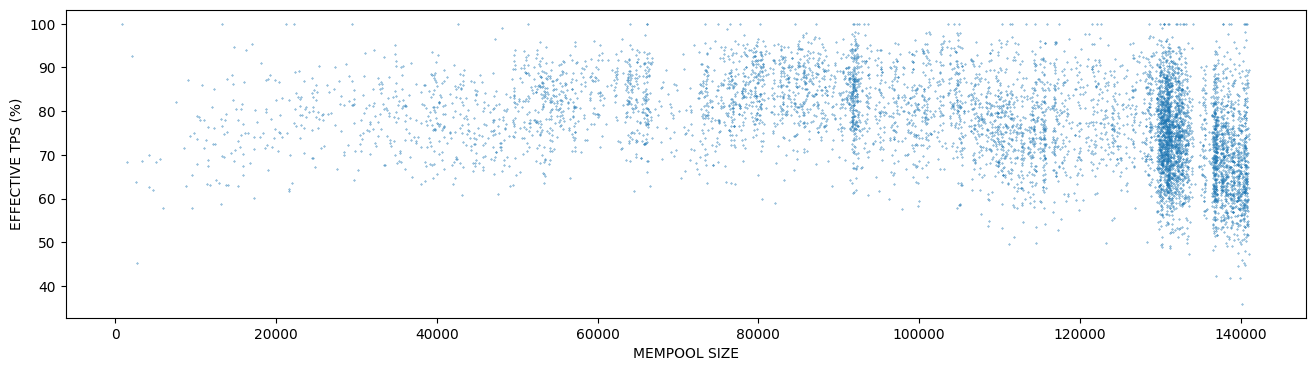

In [20]:
x = df2['mempool_count']
y = df2['etps']

plt.figure(figsize=(16, 4))
plt.scatter(x, y, s=0.1)
plt.ylabel('EFFECTIVE TPS (%)')
plt.xlabel('MEMPOOL SIZE')
plt.show()

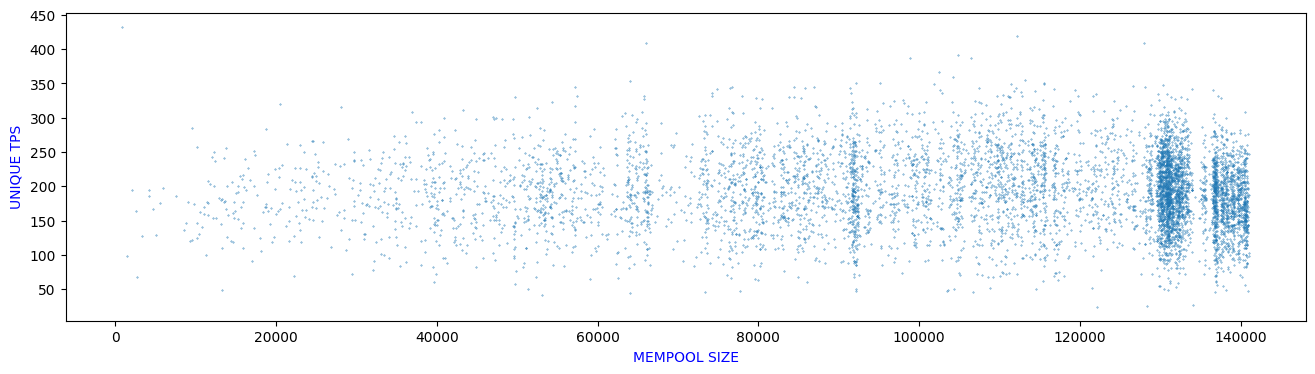

In [52]:
x = df2['mempool_count']
y = df2['utps']

plt.figure(figsize=(16, 4))
plt.scatter(x, y, s=0.1)
plt.ylabel('UNIQUE TPS', color='blue')
plt.xlabel('MEMPOOL SIZE', color='blue')
plt.show()

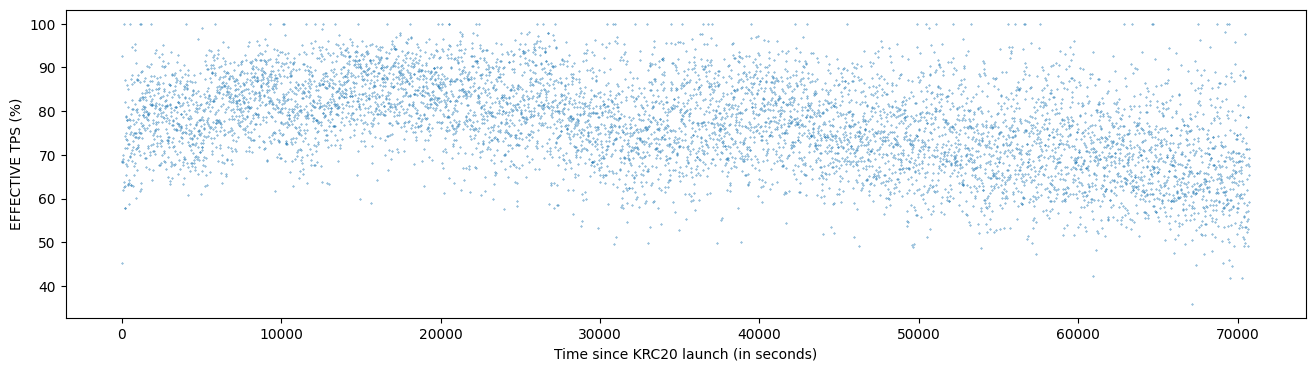

In [22]:
x = df2['timestamp']
y = df2['etps']

plt.figure(figsize=(16, 4))
plt.scatter(x - thresh, y, s=0.1)
plt.ylabel('EFFECTIVE TPS (%)')
plt.xlabel('Time since KRC20 launch (in seconds)')
plt.show()

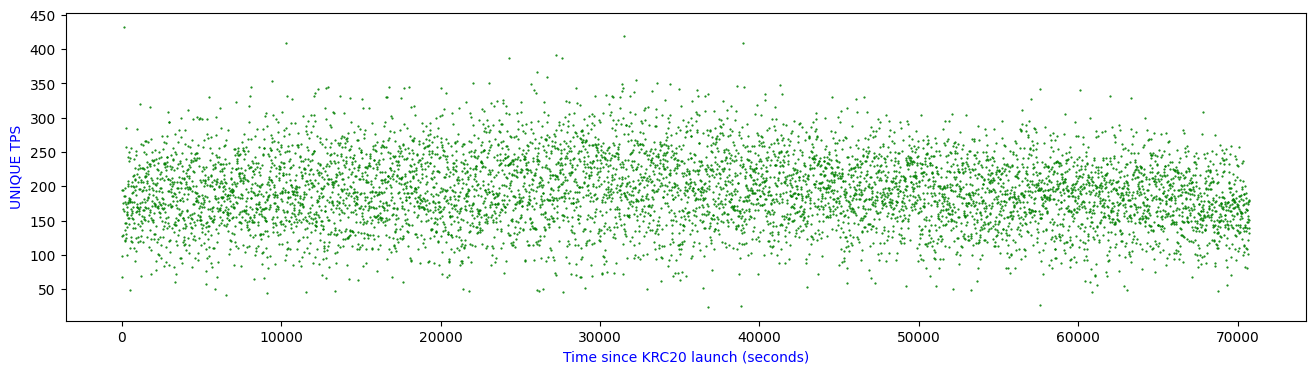

In [51]:
x = df2['timestamp']
y = df2['utps']

plt.figure(figsize=(16, 4))
plt.scatter(x - thresh, y, s=0.3, color='green')
plt.ylabel('UNIQUE TPS', color='blue')
plt.xlabel('Time since KRC20 launch (seconds)', color='blue')
plt.show()

In [24]:
# Extracted from node logs by `cat rusty-kaspa.log.1 rusty-kaspa.log | grep "Processed" > proc.log`
proc_file = 'proc.log'
proc_data = []
thresh = datetime.datetime.fromisoformat('2024-09-15 12:00:00.000+00:00').timestamp()
with open(proc_file) as file:
    for line in file:
        # Line format: 2024-09-10 23:46:52.373+00:00 [INFO ] Processed 11 blocks and 11 headers in the last 10.00s
        #              (12 transactions; 10 UTXO-validated blocks; 1.73 parents; 1.73 mergeset; 1.09 TPB; 286.7 mass)
        t = datetime.datetime.fromisoformat(line[:line.find(' [')]).timestamp()
        if t < thresh:
            continue
        if line.find('IBD') >= 0:
            continue
        blocks = float(re.search('Processed (.+?) blocks', line).group(1))
        parents = float(re.search('UTXO-validated blocks; (.+?) parents;', line).group(1))
        tpb = float(re.search('mergeset; (.+?) TPB;', line).group(1))
        mass = float(re.search('TPB; (.+?) mass', line).group(1))
        proc_data.append((t, blocks, parents, tpb, mass))
        # print(proc_data[-1])
        # break

In [25]:
df3 = pd.DataFrame(proc_data, columns=['timestamp', 'blocks', 'parents', 'tpb', 'mass'])

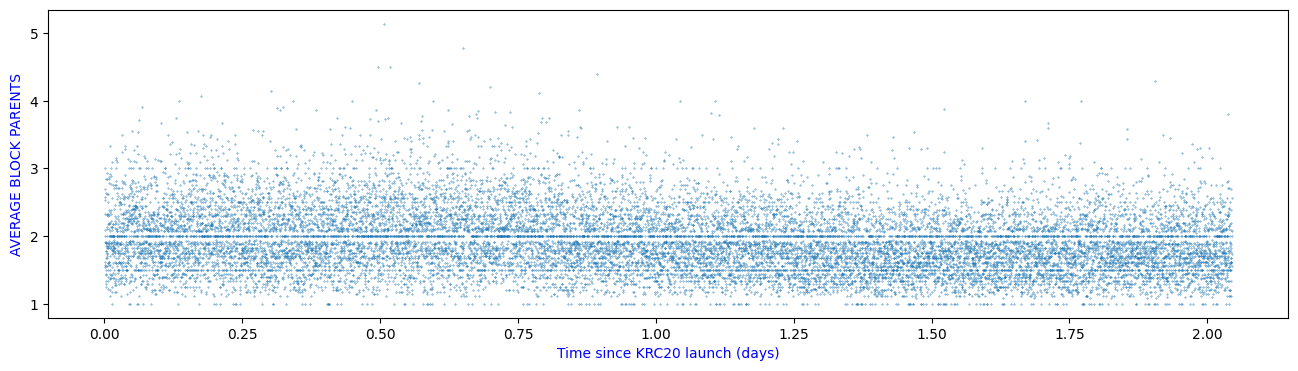

In [50]:
x = df3['timestamp']
y = df3['parents']

plt.figure(figsize=(16, 4))
plt.scatter((x - thresh)/86400, y, s=0.1)
plt.ylabel('AVERAGE BLOCK PARENTS', color='blue')
plt.xlabel('Time since KRC20 launch (days)', color='blue')
plt.show()

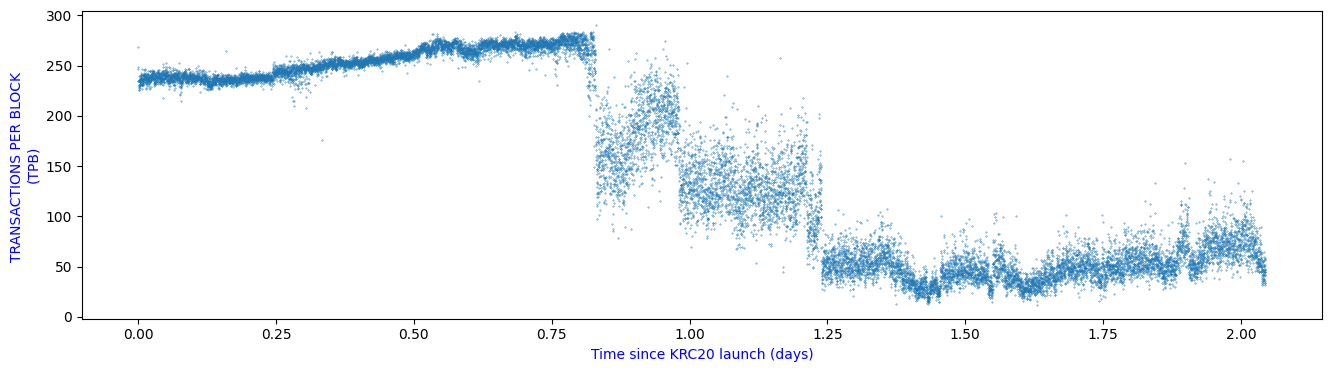

In [44]:
x = df3['timestamp']
y = df3['tpb']

plt.figure(figsize=(16, 4))
plt.scatter((x - thresh)/86400, y, s=0.1)
plt.ylabel('TRANSACTIONS PER BLOCK \n(TPB)', color='blue')
plt.xlabel('Time since KRC20 launch (days)', color='blue')
plt.show()

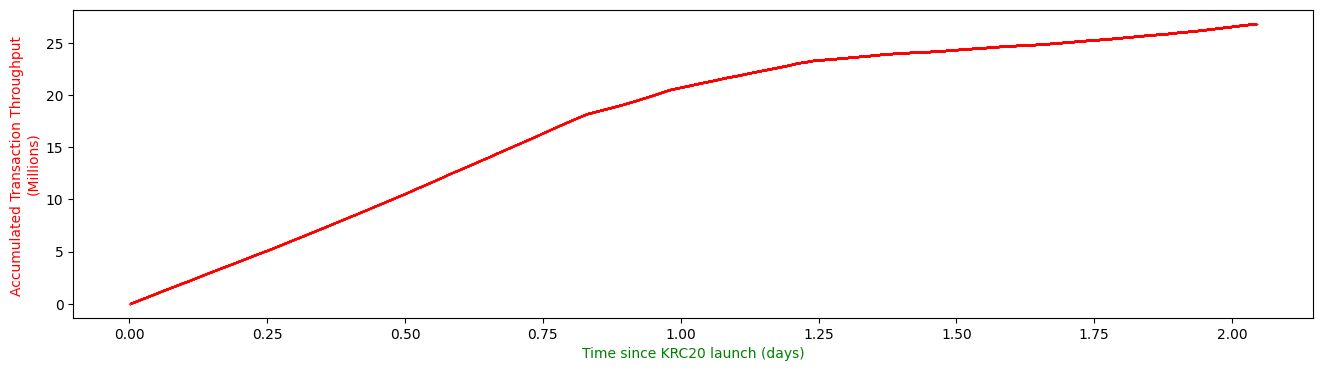

In [42]:
x = df3['timestamp']
tx_counts = df3['tpb'] * df3['blocks']
y = tx_counts.cumsum()

plt.figure(figsize=(16, 4))
plt.scatter((x - thresh)/86400, y/1_000_000, s=0.01, color='red')
plt.ylabel('Accumulated Transaction Throughput \n(Millions)', color='red')
plt.xlabel('Time since KRC20 launch (days)', color='green')
plt.show()

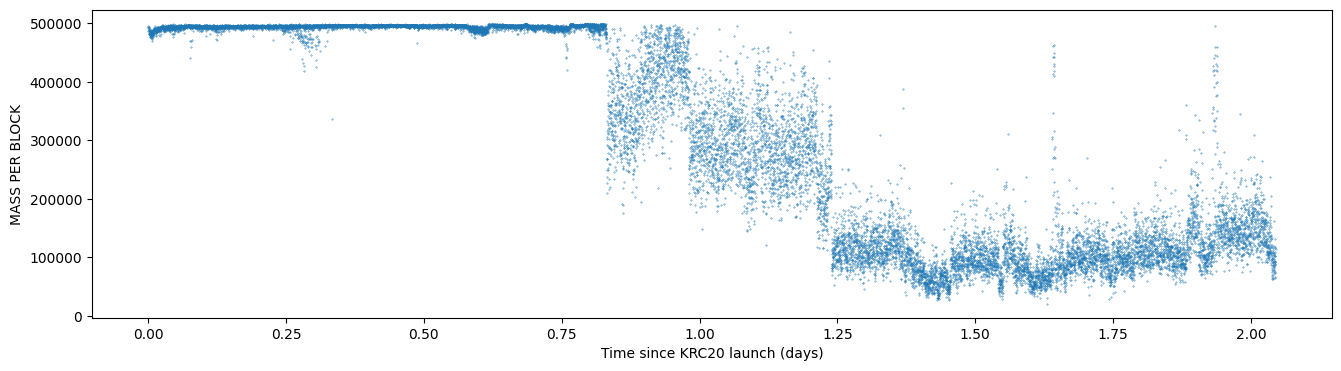

In [64]:
x = df3['timestamp']
y = df3['mass']

plt.figure(figsize=(16, 4))
plt.scatter((x - thresh)/86400, y, s=0.1)
plt.ylabel('MASS PER BLOCK')
plt.xlabel('Time since KRC20 launch (days)')
plt.show()

In [60]:
df4 = df3[df3['timestamp'] < datetime.datetime.fromisoformat('2024-09-16 12:00:00.000+00:00').timestamp()]
days = (df4['timestamp'][len(df4)-1] - df4['timestamp'][0]) / 86400
txs = sum(df4['tpb'] * df4['blocks'])
df6 = pd.DataFrame(orig_data, columns=['timestamp', 'mempool_count', 'utps', 'etps'])
df5 = df6[df6['timestamp'] < datetime.datetime.fromisoformat('2024-09-16 12:00:00.000+00:00').timestamp()]
unique_txs = df5['utps'].mean() * 86400
print('Number of INCLUDED\ttransactions in the first {0:.2f} days:\t{1:.2f}M'.format(days, txs/1_000_000))
print('Number of UNIQUE\ttransactions in the first {0:.2f} days:\t{1:.2f}M'.format(days, unique_txs/1_000_000))

Number of INCLUDED	transactions in the first 1.00 days:	20.74M
Number of UNIQUE	transactions in the first 1.00 days:	15.14M


In [59]:
len(df5['utps']), len(df4)

(8609, 8633)

In [61]:
unique_txs / 86400

175.26450807294694

In [62]:
max(df2['mempool_count'])

141067.0

In [63]:
txs / 86400

240.02199965277748

In [66]:
df4 = df3[df3['timestamp'] < datetime.datetime.fromisoformat('2024-09-17 12:00:00.000+00:00').timestamp()]
days = (df4['timestamp'][len(df4)-1] - df4['timestamp'][0]) / 86400
txs = sum(df4['tpb'] * df4['blocks'])
df6 = pd.DataFrame(orig_data, columns=['timestamp', 'mempool_count', 'utps', 'etps'])
df5 = df6[df6['timestamp'] < datetime.datetime.fromisoformat('2024-09-17 12:00:00.000+00:00').timestamp()]
unique_txs = df5['utps'].mean() * days * 86400
print('Number of INCLUDED\ttransactions in the first {0:.2f} days:\t{1:.2f}M'.format(days, txs/1_000_000))
print('Number of UNIQUE\ttransactions in the first {0:.2f} days:\t{1:.2f}M'.format(days, unique_txs/1_000_000))

Number of INCLUDED	transactions in the first 2.00 days:	26.57M
Number of UNIQUE	transactions in the first 2.00 days:	18.15M
